---
# <div align="center"><font color='green'> COSC 2673/2793 | Machine Learning  </font></div>
## <div align="center"> <font color='green'>Assignment 2: Machine Learning Project</font></div><div align="center"> <font color='green'>Type classification</font></div>
---



# Import and read data

In [2]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import losses
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_recall_fscore_support, precision_score, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

Lets import the data.

In [109]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cp /content/drive/'My Drive'/Assignment2_Machine_Learning/trafficsigns_dataset.zip . # to change depending on where you unzip our work

Unzip the repertory with the images dataset

In [5]:
# path to zip
zip_file_path = "./trafficsigns_dataset.zip"

# path to repertory where images will be extracted
extracted_dir = "./"

# zip extraction
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# remove what we do not need
!rm -r __MACOSX/
!rm -r sample_data/

data_dir = extracted_dir + "trafficsigns_dataset"

# Create data frames

In [6]:
files_names = []
shapes_list = []
types_list = []

for shape in os.listdir(data_dir):
  if((shape!="Readme.txt") and (shape!=".DS_Store" )):
    shape_path = os.path.join(data_dir, shape)
    if os.path.isdir(shape_path):
      for type in os.listdir(shape_path):
        if((type!="Readme.txt") and (type!=".DS_Store" )):
          shape_type_path = os.path.join(shape_path, type)
          if os.path.isdir(shape_type_path):
            for image in os.listdir(shape_type_path):
              if((image!="Readme.txt") and (image!=".DS_Store" )):
                image_path = os.path.join(shape_type_path, image)
                files_names.append(image_path)
                types_list.append(type)
                shapes_list.append(shape)


# creation of a new column with shapes/types encoded
from sklearn.preprocessing import LabelEncoder
shape_encoder = LabelEncoder()
type_encoder = LabelEncoder()
shapes_int = shape_encoder.fit_transform(shapes_list)
types_int = type_encoder.fit_transform(types_list)

shape_values = shape_encoder.classes_
type_values = type_encoder.classes_

type_class_labels = []

# Display the integer associated to the value
for integer, value in enumerate(shape_values):
    print(f"{integer}: {value}")
print('\n')
for integer, value in enumerate(type_values):
    print(f"{integer}: {value}")
    type_class_labels.append(value)

# shapes
# pandas dataframe creation
df1 = pd.DataFrame({"File Name": files_names, "Shape": shapes_list, "ID shape": shapes_int})
# write in CSV
df1.to_csv("signs_shape.csv", index=False)

# types
# pandas dataframe creation
df2 = pd.DataFrame({"File Name": files_names, "Type": types_list, "ID type": types_int})
# write in CSV
df2.to_csv("signs_type.csv", index=False)

0: diamond
1: hex
2: round
3: square
4: triangle


0: bicycle
1: continue
2: crossing
3: giveway
4: laneend
5: limitedtraffic
6: noentry
7: noparking
8: parking
9: rightofway
10: roundabout
11: speed
12: stop
13: trafficdirective
14: traveldirection
15: warning


# EDA

In [7]:
# number of images

images_count = len(df1['File Name'])
print("Nb of images :", images_count, "\n")

Nb of images : 3699 



## Sign-type EDA

Nb of types : 16  ( 16 -ary class) 

Number of images in each type class
Type
warning             695
noentry             375
speed               316
bicycle             285
rightofway          282
parking             276
noparking           242
giveway             231
continue            199
trafficdirective    195
limitedtraffic      125
traveldirection     124
laneend             118
roundabout           98
crossing             95
stop                 43
Name: count, dtype: int64


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'giveway'),
  Text(1, 0, 'warning'),
  Text(2, 0, 'rightofway'),
  Text(3, 0, 'crossing'),
  Text(4, 0, 'continue'),
  Text(5, 0, 'parking'),
  Text(6, 0, 'laneend'),
  Text(7, 0, 'stop'),
  Text(8, 0, 'roundabout'),
  Text(9, 0, 'limitedtraffic'),
  Text(10, 0, 'noentry'),
  Text(11, 0, 'bicycle'),
  Text(12, 0, 'trafficdirective'),
  Text(13, 0, 'speed'),
  Text(14, 0, 'noparking'),
  Text(15, 0, 'traveldirection')])

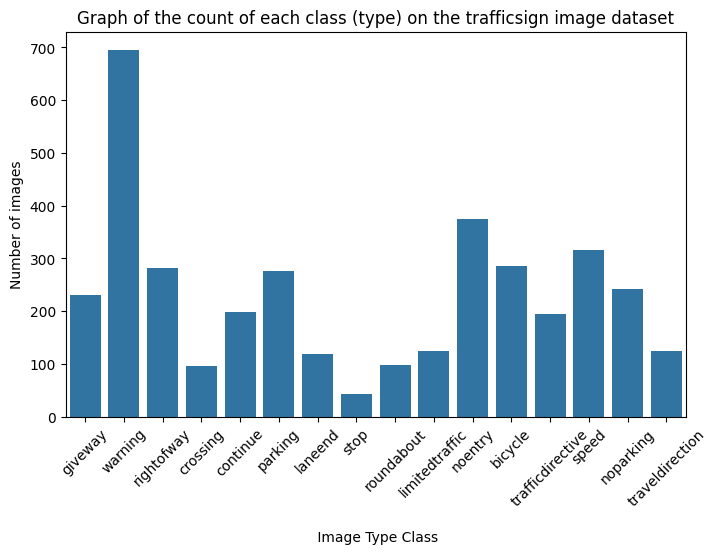

In [8]:
# number of unique values

type_unique_values = set(types_int)
type_number = len(type_unique_values)

print("Nb of types :", type_number, " (", type_number, "-ary class)", "\n")

print('Number of images in each type class')
print(df2['Type'].value_counts())



fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(data=df2, x='Type')
plt.title('Graph of the count of each class (type) on the trafficsign image dataset')
plt.xlabel('\n Image Type Class')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

> <span style="font-size:1em;">✔</span> **Observations:**

There are some label imbalance in our dataset and the task is multi-class classification (16-ary class).
A performance measure such as Accuracy can be inadequate for this task. We decide to use precision, recall, and F1-score instead.

Let's try to plot some of the images


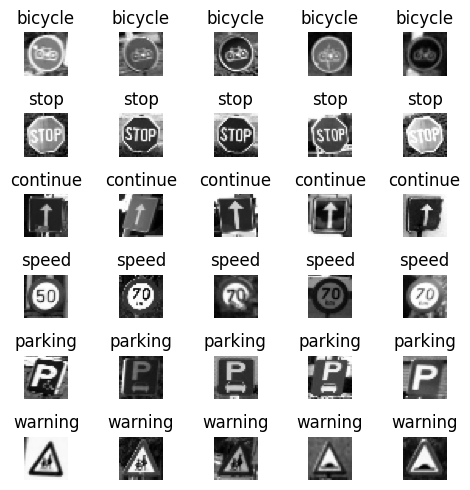

In [9]:
# get the lists of images from diffent type directories
bicycle_imgs = [ pic for pic in os.listdir('trafficsigns_dataset/round/bicycle') ]
stop_imgs = [ pic for pic in os.listdir('trafficsigns_dataset/hex/stop') ]
continue_imgs = [ pic for pic in os.listdir('trafficsigns_dataset/square/continue') ]
speed_imgs = [ pic for pic in os.listdir('trafficsigns_dataset/round/speed') ]
parking_imgs = [ pic for pic in os.listdir('trafficsigns_dataset/square/parking') ]
warning_imgs = [ pic for pic in os.listdir('trafficsigns_dataset/triangle/warning') ]

# randomly select 3 of each
select_bicycle = np.random.choice(bicycle_imgs, 5, replace = False)
select_stop = np.random.choice(stop_imgs, 5, replace = False)
select_continue = np.random.choice(continue_imgs, 5, replace = False)
select_speed = np.random.choice(speed_imgs, 5, replace = False)
select_parking = np.random.choice(parking_imgs, 5, replace = False)
select_warning = np.random.choice(warning_imgs, 5, replace = False)

# plotting 5 x 5 image matrix
fig = plt.figure(figsize = (5,5))

for i in range(30):
    if i < 5:
        img = f'trafficsigns_dataset/round/bicycle/{select_bicycle[i]}'
        label = 'bicycle'
    elif i >= 5 and i < 10:
        img = f'trafficsigns_dataset/hex/stop/{select_stop[i-5]}'
        label = 'stop'
    elif i >= 10 and i < 15:
        img = f'trafficsigns_dataset/square/continue/{select_continue[i-10]}'
        label = 'continue'
    elif i >= 15 and i < 20:
        img = f'trafficsigns_dataset/round/speed/{select_speed[i-15]}'
        label = 'speed'
    elif i >= 20 and i < 25:
        img = f'trafficsigns_dataset/square/parking/{select_parking[i-20]}'
        label = 'parking'
    elif i >= 25 and i < 30:
        img = f'trafficsigns_dataset/triangle/warning/{select_warning[i-25]}'
        label = 'warning'

    ax = fig.add_subplot(6, 5, i+1)

    to_plot = load_img(img, target_size = (100,100), color_mode='grayscale')
    plt.imshow(to_plot, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()


# https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

# Data splitting

Lets randomly split the data into train/val/test.

In [10]:
data = pd.read_csv('./signs_type.csv')

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))
print("\n")
print(test_data)

Train data : 2219, Val Data: 740, Test Data: 740


                                              File Name              Type  \
1042  ./trafficsigns_dataset/diamond/rightofway/0193...        rightofway   
2460  ./trafficsigns_dataset/round/noentry/00954_000...           noentry   
315   ./trafficsigns_dataset/triangle/warning/01782_...           warning   
3523  ./trafficsigns_dataset/round/noparking/01468_0...         noparking   
811   ./trafficsigns_dataset/triangle/warning/00220_...           warning   
...                                                 ...               ...   
507   ./trafficsigns_dataset/triangle/warning/00261_...           warning   
7     ./trafficsigns_dataset/triangle/giveway/01895_...           giveway   
3084  ./trafficsigns_dataset/round/speed/01244_00002...             speed   
2828  ./trafficsigns_dataset/round/trafficdirective/...  trafficdirective   
2886  ./trafficsigns_dataset/round/trafficdirective/...  trafficdirective   

      ID type  
1042    

# Diagnostic tool

Let's write a function to plot the learning curves of a NN training process (taken from week 6 lab). This will be our diagnostic tool.

In [11]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, label1, label2):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(label1)
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylim(0, 2.75)

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(label2)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

# https://www.tensorflow.org/tutorials/images/classification?hl=fr

# Base Model: 2 hidden-layers Neural Network

## Setup the layers

In [36]:
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 16

Like in the lab, we use tensorflow and the `Sequential` API to build models as it is the simplest.

In [37]:
# creates an instance of a sequential model (a linear stack of layers where data passes from the first layer to the last layer in the specified order)

type_base_model = Sequential([
    Flatten(input_shape=INPUT_DIM),
    Dense(500, activation='relu'),
    Dense(500, activation='relu'),
    Dense(OUTPUT_CLASSES)
])

Neural network with four layers:
- The input layer (its dimension is the dimension of the image).
The function used transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 * 3 = 2352 pixels).
- Two dense hidden-layers (their size are a hyper parameter that can be tuned)
- The output layer (16 neurons; each neuron correspond to a class/sign type)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2352)              0         
                                                                 
 dense_3 (Dense)             (None, 500)               1176500   
                                                                 
 dense_4 (Dense)             (None, 500)               250500    
                                                                 
 dense_5 (Dense)             (None, 16)                8016      
                                                                 
Total params: 1435016 (5.47 MB)
Trainable params: 1435016 (5.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


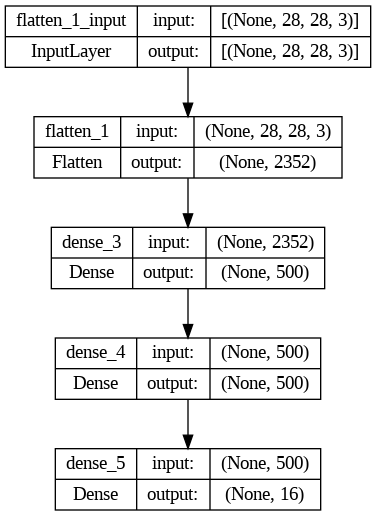

In [38]:
type_base_model.summary()

plot_model(type_base_model, show_shapes=True)

## Compile the model

In [39]:
type_base_model.compile(optimizer='SGD',
              loss=losses.CategoricalCrossentropy(from_logits=True),
              metrics=['Recall', 'Precision'])

## Load the data in batches to memory

Efficient code to load the data in batches to memory:

In [40]:
train_data['Type'] = train_data['Type'].astype('str')
val_data['Type'] = val_data['Type'].astype('str')

In [41]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="File Name",
        y_col="Type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="File Name",
        y_col="Type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


## Train the model

In [42]:
history = type_base_model.fit_generator(train_generator, validation_data = validation_generator, epochs=40, verbose=0)

<ipython-input-42-0aa789fd3f14>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = type_base_model.fit_generator(train_generator, validation_data = validation_generator, epochs=40, verbose=0)


In [43]:
print(history.history.keys())

dict_keys(['loss', 'recall', 'precision', 'val_loss', 'val_recall', 'val_precision'])


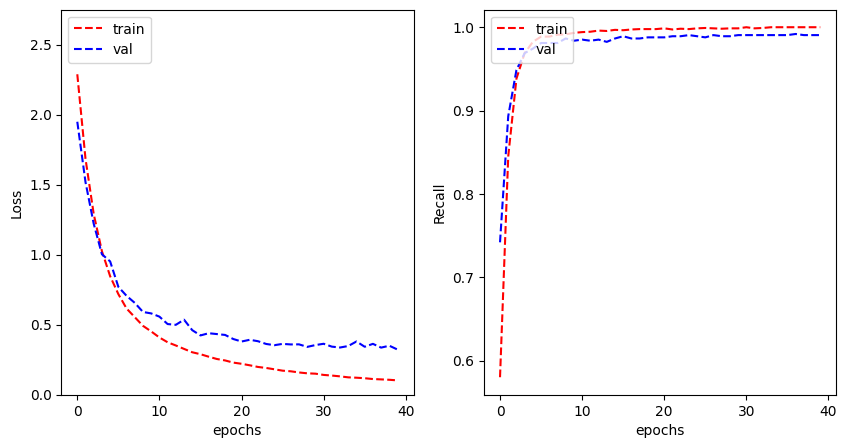

In [82]:
plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['recall'], history.history['val_recall'],
                    label1='Loss', label2='Recall')

In [45]:
evaluation_results = type_base_model.evaluate(train_generator)
evaluation_results = type_base_model.evaluate(validation_generator)

24/24 [==============================] - 0s 14ms/step - loss: 0.3226 - recall: 0.9905 - precision: 0.1384


## Save the model

In [47]:
type_base_model.save("type_base_model")
!cp -R ./type_base_model /content/drive/'My Drive'/Assignment2_Machine_Learning/ # to change depending on where you unzip our work

## Testing the model

Let's use the test dataframe created previously:

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="File Name",
        y_col="Type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 740 validated image filenames belonging to 16 classes.


In [ ]:
type_class_labels = list(test_generator.class_indices.keys())
print(type_class_labels)

['bicycle', 'continue', 'crossing', 'giveway', 'laneend', 'limitedtraffic', 'noentry', 'noparking', 'parking', 'rightofway', 'roundabout', 'speed', 'stop', 'trafficdirective', 'traveldirection', 'warning']


In [ ]:
evaluation_results = type_base_model.evaluate(test_generator)

740/740 [==============================] - 7s 9ms/step - loss: 0.3018 - categorical_accuracy: 0.9189 - recall: 0.9932 - precision: 0.1274


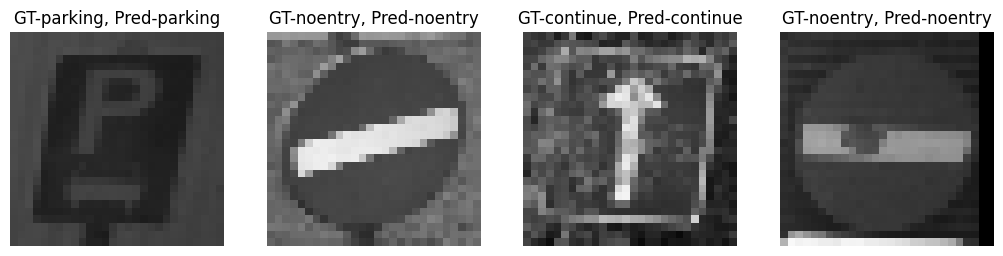

In [ ]:
plt.figure(figsize=(16,16))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = type_base_model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x, cmap='gray')
            plt.title("GT-{}, Pred-{}".format(type_class_labels[np.argmax(y[0])], type_class_labels[np.argmax(y_hat[0])] ))

        else:
            break

        plt.axis('off')

## Predict all the test set and add it to the test_data dataframe

In [84]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# Predictions for each image of the dataFrame
typePredictionsList = []
i = 0
for index, row in test_data.iterrows():
    i = i + 1
    print(i)
    img_path = row['File Name']
    image = load_img(img_path, target_size=(28, 28))
    img_array = img_to_array(image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = test_datagen.standardize(img_array)
    prediction = type_base_model.predict(img_array)
    typePredictionsList.append(prediction)

typePredictionsList = np.concatenate(typePredictionsList, axis=0)

res = []
for j in range(len(typePredictionsList)):
  res.append(type_class_labels[np.argmax(typePredictionsList[j])])

# add the predictions to the dataFrame
test_data['Type Predictions base model'] = res
print(test_data['Type'], test_data['Type Predictions base model'])

1
1/1 [==============================] - 0s 72ms/step
2
1/1 [==============================] - 0s 25ms/step
3
1/1 [==============================] - 0s 23ms/step
4
1/1 [==============================] - 0s 22ms/step
5
1/1 [==============================] - 0s 25ms/step
6
1/1 [==============================] - 0s 21ms/step
7
1/1 [==============================] - 0s 23ms/step
8
1/1 [==============================] - 0s 22ms/step
9
1/1 [==============================] - 0s 23ms/step
10
1/1 [==============================] - 0s 24ms/step
11
1/1 [==============================] - 0s 23ms/step
12
1/1 [==============================] - 0s 26ms/step
13
1/1 [==============================] - 0s 33ms/step
14
1/1 [==============================] - 0s 25ms/step
15
1/1 [==============================] - 0s 26ms/step
16
1/1 [==============================] - 0s 24ms/step
17
1/1 [==============================] - 0s 23ms/step
18
1/1 [==============================] - 0s 22ms/step
19
1/1 [===========

In [85]:
print("Base model:")
print("f1-score average micro: ", f1_score(test_data['Type'],test_data['Type Predictions base model'], average='micro'))
print("f1-score average macro: ", f1_score(test_data['Type'],test_data['Type Predictions base model'], average='macro'))
print("f1-score average weighted: ", f1_score(test_data['Type'],test_data['Type Predictions base model'], average='weighted'))

print("\n")
print(precision_score(test_data['Type'],test_data['Type Predictions base model'], average='weighted'))
print(recall_score(test_data['Type'],test_data['Type Predictions base model'], average='weighted'))

# Le F1-score micro est calculé en prenant en compte les vrais positifs, les faux positifs et les faux négatifs globalement sur toutes les classes, ce qui est essentiellement ce que l'accuracy mesure également.
# Le F1-score macro calcule la moyenne des F1-scores de chaque classe sans considération du déséquilibre des classes.

Base model:
f1-score average micro:  0.9567567567567568
f1-score average macro:  0.9569938004961371
f1-score average weighted:  0.9575528186567991


0.9595645351710042
0.9567567567567568


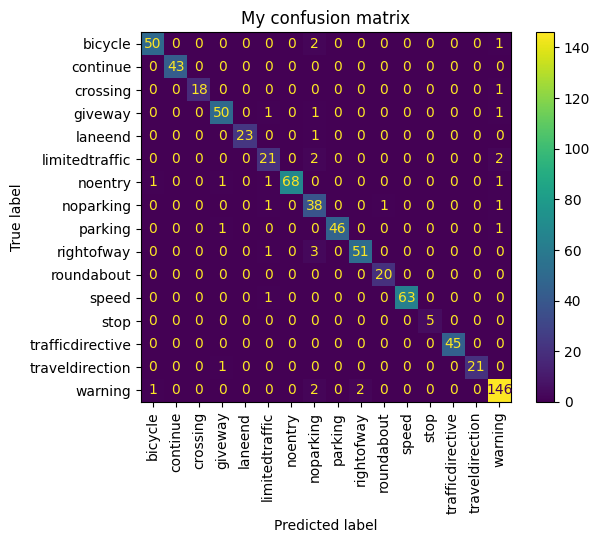

In [86]:
cm = confusion_matrix(test_data['Type'], test_data['Type Predictions base model'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=type_class_labels)
disp.plot()
plt.title("My confusion matrix")
plt.xticks(rotation = 'vertical')
plt.show()

# Second model: VGG 3 & 4

Let's do the same process but with other models:

In [87]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="File Name",
        y_col="Type",
        target_size=(28,28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="File Name",
        y_col="Type",
        target_size=(28,28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [88]:
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 16

In [90]:
type_model_VGG = Sequential([
    #VGG block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    #VGG block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    #VGG block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Comment this block to have the VGG 3 model
    # VGG block 4
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),


    Flatten(),
    Dense(128, activation='relu'),
    Dense(OUTPUT_CLASSES)
])

In [91]:
type_model_VGG.compile(optimizer='adam',
              loss=losses.CategoricalCrossentropy(from_logits=True),
              metrics=['Recall', 'Precision'])

In [92]:
history_VGG = type_model_VGG.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

<ipython-input-92-96456406e526>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_VGG = type_model_VGG.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


In [ ]:
type_model_VGG.save("type_model_VGG_4")
!cp -R ./type_model_VGG_4 /content/drive/'My Drive'/Assignment2_Machine_Learning/ # to change depending on where you unzip our work

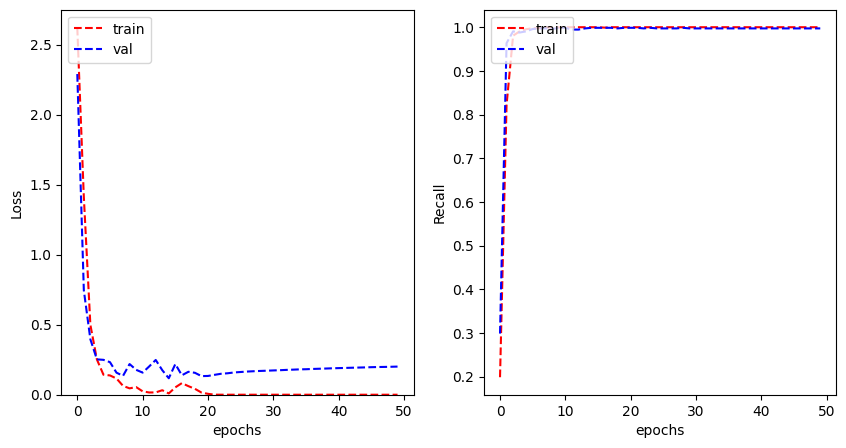

In [94]:
plot_learning_curve(history_VGG.history['loss'], history_VGG.history['val_loss'],
                    history_VGG.history['recall'], history_VGG.history['val_recall'],
                    label1='Loss', label2='Recall')

In [101]:
evaluation_results = type_model_VGG.evaluate(train_generator)
evaluation_results = type_model_VGG.evaluate(validation_generator)

24/24 [==============================] - 1s 53ms/step - loss: 0.2010 - recall: 0.9973 - precision: 0.2162


In [103]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="File Name",
        y_col="Type",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 740 validated image filenames belonging to 16 classes.


In [104]:
evaluation_results = type_model_VGG.evaluate(test_generator)

740/740 [==============================] - 6s 8ms/step - loss: 0.2752 - recall: 0.9973 - precision: 0.2130


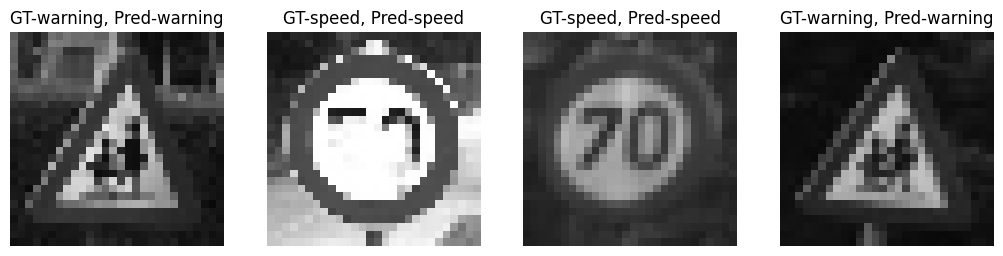

In [105]:
plt.figure(figsize=(16,16))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = type_model_VGG.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x, cmap='gray')
            plt.title("GT-{}, Pred-{}".format(type_class_labels[np.argmax(y[0])], type_class_labels[np.argmax(y_hat[0])] ))

        else:
            break

        plt.axis('off')

In [106]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# Prédictions pour chaque image dans le DataFrame
typePredictionsList = []
i = 0
for index, row in test_data.iterrows():
    i = i + 1
    print(i)
    img_path = row['File Name']
    image = load_img(img_path, target_size=(28, 28))
    img_array = img_to_array(image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = test_datagen.standardize(img_array)
    prediction = type_model_VGG.predict(img_array)
    typePredictionsList.append(prediction)

typePredictionsList = np.concatenate(typePredictionsList, axis=0)

res = []
for j in range(len(typePredictionsList)):
  res.append(type_class_labels[np.argmax(typePredictionsList[j])])

# Ajoute les prédictions au DataFrame
test_data['Type_Predictions_VGG'] = res
print(test_data['Type'], test_data['Type_Predictions_VGG'])

1
1/1 [==============================] - 0s 34ms/step
2
1/1 [==============================] - 0s 36ms/step
3
1/1 [==============================] - 0s 39ms/step
4
1/1 [==============================] - 0s 51ms/step
5
1/1 [==============================] - 0s 43ms/step
6
1/1 [==============================] - 0s 37ms/step
7
1/1 [==============================] - 0s 41ms/step
8
1/1 [==============================] - 0s 39ms/step
9
1/1 [==============================] - 0s 37ms/step
10
1/1 [==============================] - 0s 50ms/step
11
1/1 [==============================] - 0s 39ms/step
12
1/1 [==============================] - 0s 52ms/step
13
1/1 [==============================] - 0s 35ms/step
14
1/1 [==============================] - 0s 36ms/step
15
1/1 [==============================] - 0s 50ms/step
16
1/1 [==============================] - 0s 37ms/step
17
1/1 [==============================] - 0s 35ms/step
18
1/1 [==============================] - 0s 36ms/step
19
1/1 [===========

VGG 4 model:

f1-score average micro:  0.9702702702702702
f1-score average macro:  0.9596178889961737
f1-score average weighted:  0.9703201807270765


Precision score average weighted:  0.9725609494545665
Recall score average weighted:  0.9702702702702702


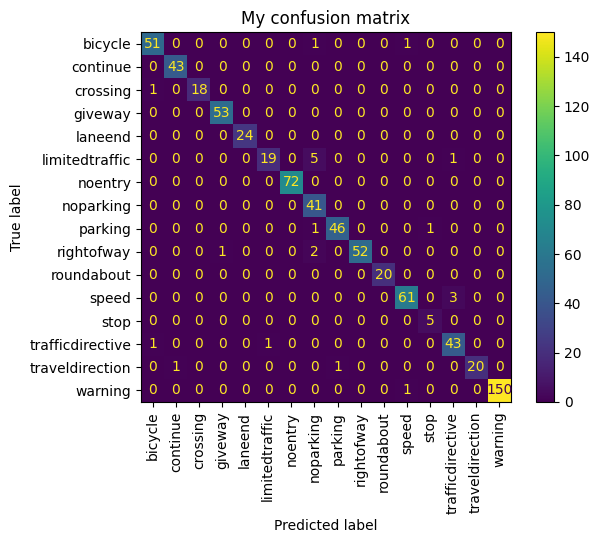

In [108]:
print("VGG 4 model:\n")
print("f1-score average micro: ", f1_score(test_data['Type'],test_data['Type_Predictions_VGG'], average='micro'))
print("f1-score average macro: ", f1_score(test_data['Type'],test_data['Type_Predictions_VGG'], average='macro'))
print("f1-score average weighted: ", f1_score(test_data['Type'],test_data['Type_Predictions_VGG'], average='weighted'))

print("\n")
print("Precision score average weighted: ", precision_score(test_data['Type'],test_data['Type_Predictions_VGG'], average='weighted'))
print("Recall score average weighted: ", recall_score(test_data['Type'],test_data['Type_Predictions_VGG'], average='weighted'))


cm = confusion_matrix(test_data['Type'], test_data['Type_Predictions_VGG'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=type_class_labels)
disp.plot()
plt.title("My confusion matrix")
plt.xticks(rotation = 'vertical')
plt.show()

# Load the models

After training the models, we save them to be able to use them without reexecuting all the code

In [114]:
!cp -r /content/drive/'My Drive'/Assignment2_Machine_Learning/type_base_model .
!cp -r /content/drive/'My Drive'/Assignment2_Machine_Learning/type_model_VGG_3 .
!cp -r /content/drive/'My Drive'/Assignment2_Machine_Learning/type_model_VGG_4 .

type_base_model = load_model("/content/drive/My Drive/Assignment2_Machine_Learning/type_base_model") # to change depending on where you unzip our work
type_model_VGG_3 = load_model("/content/drive/My Drive/Assignment2_Machine_Learning/type_model_VGG_3") # to change depending on where you unzip our work
type_model_VGG_4 = load_model("/content/drive/My Drive/Assignment2_Machine_Learning/type_model_VGG_4") # to change depending on where you unzip our work

# New dataset

## Import the dataset and create shape and type dataframes

In [110]:
!cp /content/drive/'My Drive'/Assignment2_Machine_Learning/Independant_Evaluation_dataset.zip . # to change depending on where you unzip our work

In [111]:
# path to zip
zip_file_path = "./Independant_Evaluation_dataset.zip"

# path to repertory where the directiory content will be extracted
extracted_dir = "./"

# zip extraction
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# remove what we do not need
!rm -r __MACOSX/
!rm -r sample_data/

new_data_dir = extracted_dir + "Independant_Evaluation"

rm: cannot remove '__MACOSX/': No such file or directory
rm: cannot remove 'sample_data/': No such file or directory


Creation of the dataframes:

In [115]:
files_names = []
shapes_list = []
types_list = []

for shape in os.listdir(new_data_dir):
  shape_path = os.path.join(new_data_dir, shape)
  if os.path.isdir(shape_path):
    for type in os.listdir(shape_path):
      shape_type_path = os.path.join(shape_path, type)
      if os.path.isdir(shape_type_path):
        for image in os.listdir(shape_type_path):
          image_path = os.path.join(shape_type_path, image)
          files_names.append(image_path)
          types_list.append(type)
          shapes_list.append(shape)

# shapes
# pandas dataframe creation
new_df1 = pd.DataFrame({"File path": files_names, "Shape": shapes_list})
# write in CSV
new_df1.to_csv("new_signs_shape.csv", index=False)

# types
# pandas dataframe creation
new_df2 = pd.DataFrame({"File path": files_names, "Type": types_list})
# write in CSV
new_df2.to_csv("new_signs_type.csv", index=False)

## Analyse/check the new dataset

In [116]:
# number of images

images_count = len(new_df1['File path'])
print("Nb of images :", images_count, "\n")

Nb of images : 483 



Number of images in each type class
Type
warning             70
speed               62
giveway             49
rightofway          47
stop                41
trafficdirective    35
traveldirection     34
limitedtraffic      33
noentry             28
roundabout          22
crossing            18
bicycle             18
noparking           11
parking              8
laneend              4
continue             3
Name: count, dtype: int64


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'giveway'),
  Text(1, 0, 'warning'),
  Text(2, 0, 'rightofway'),
  Text(3, 0, 'crossing'),
  Text(4, 0, 'continue'),
  Text(5, 0, 'parking'),
  Text(6, 0, 'laneend'),
  Text(7, 0, 'stop'),
  Text(8, 0, 'roundabout'),
  Text(9, 0, 'limitedtraffic'),
  Text(10, 0, 'noentry'),
  Text(11, 0, 'bicycle'),
  Text(12, 0, 'trafficdirective'),
  Text(13, 0, 'speed'),
  Text(14, 0, 'noparking'),
  Text(15, 0, 'traveldirection')])

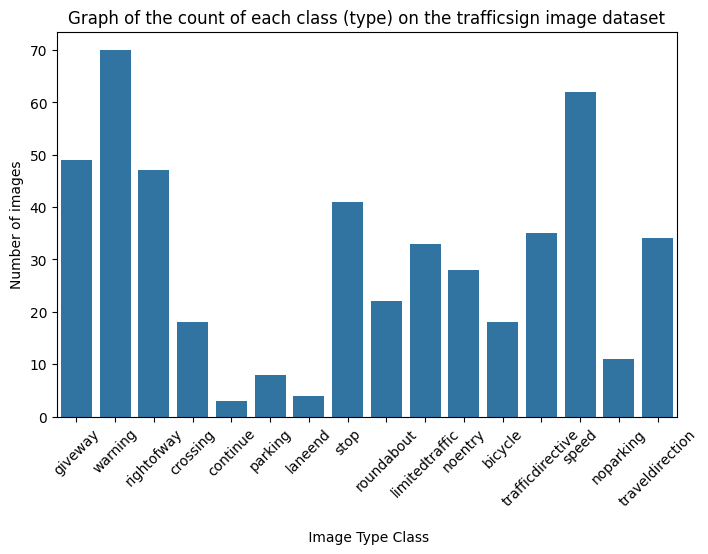

In [117]:
print('Number of images in each type class')
print(new_df2['Type'].value_counts())

fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(data=new_df2, x='Type')
plt.title('Graph of the count of each class (type) on the trafficsign image dataset')
plt.xlabel('\n Image Type Class')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

## Make type classifications with the two models

### Import the dataframe

In [118]:
new_data = pd.read_csv('./new_signs_type.csv')

### Classification with the base model

In [119]:
new_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# Predictions for each image of the dataFrame
typePredictionsList_base_model = []
typePredictionsList_VGG3_model = []
typePredictionsList_VGG4_model = []
i = 0
for index, row in new_data.iterrows():
    i = i + 1
    print(i)
    img_path = row['File path']
    image = load_img(img_path, target_size=(28, 28))
    img_array = img_to_array(image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = new_datagen.standardize(img_array)

    base_model_prediction = type_base_model.predict(img_array)
    typePredictionsList_base_model.append(base_model_prediction)

    VGG_model_prediction = type_model_VGG_3.predict(img_array)
    typePredictionsList_VGG3_model.append(VGG_model_prediction)

    VGG4_model_prediction = type_model_VGG_4.predict(img_array)
    typePredictionsList_VGG4_model.append(VGG4_model_prediction)


typePredictionsList_base_model = np.concatenate(typePredictionsList_base_model, axis=0)
typePredictionsList_VGG3_model = np.concatenate(typePredictionsList_VGG3_model, axis=0)
typePredictionsList_VGG4_model = np.concatenate(typePredictionsList_VGG4_model, axis=0)

res_base = []
res_VGG3 = []
res_VGG4 = []
for j in range(len(typePredictionsList_base_model)):
  res_base.append(type_class_labels[np.argmax(typePredictionsList_base_model[j])])
  res_VGG3.append(type_class_labels[np.argmax(typePredictionsList_VGG3_model[j])])
  res_VGG4.append(type_class_labels[np.argmax(typePredictionsList_VGG4_model[j])])

# add the predictions to the dataFrame
new_data['Type base model'] = res_base
new_data['Type VGG 3 model'] = res_VGG3
new_data['Type VGG 4 model'] = res_VGG4

1
1/1 [==============================] - 0s 122ms/step
2
1/1 [==============================] - 0s 25ms/step
3
1/1 [==============================] - 0s 24ms/step
4
1/1 [==============================] - 0s 24ms/step
5
1/1 [==============================] - 0s 25ms/step
6
1/1 [==============================] - 0s 23ms/step
7
1/1 [==============================] - 0s 27ms/step
8
1/1 [==============================] - 0s 33ms/step
9
1/1 [==============================] - 0s 22ms/step
10
1/1 [==============================] - 0s 22ms/step
11
1/1 [==============================] - 0s 24ms/step
12
1/1 [==============================] - 0s 23ms/step
13
1/1 [==============================] - 0s 23ms/step
14
1/1 [==============================] - 0s 22ms/step
15
1/1 [==============================] - 0s 22ms/step
16
1/1 [==============================] - 0s 22ms/step
17
1/1 [==============================] - 0s 24ms/step
18
1/1 [==============================] - 0s 23ms/step
19
1/1 [==========

### Analyse the results

In [120]:
print("Base model:")
print("f1-score average micro: ", f1_score(new_data['Type'],new_data['Type base model'], average='micro'))
print("f1-score average macro: ", f1_score(new_data['Type'],new_data['Type base model'], average='macro'))
print("f1-score average weighted: ", f1_score(new_data['Type'],new_data['Type base model'], average='weighted'))

print("\n")
print("VGG 3 model:\n")
print("f1-score average micro: ", f1_score(new_data['Type'],new_data['Type VGG 3 model'], average='micro'))
print("f1-score average macro: ", f1_score(new_data['Type'],new_data['Type VGG 3 model'], average='macro'))
print("f1-score average weighted: ", f1_score(new_data['Type'],new_data['Type VGG 3 model'], average='weighted'))

print("\n")
print("VGG 4 model:\n")
print("f1-score average micro: ", f1_score(new_data['Type'],new_data['Type VGG 4 model'], average='micro'))
print("f1-score average macro: ", f1_score(new_data['Type'],new_data['Type VGG 4 model'], average='macro'))
print("f1-score average weighted: ", f1_score(new_data['Type'],new_data['Type VGG 4 model'], average='weighted'))

Base model:
f1-score average micro:  0.40372670807453415
f1-score average macro:  0.34239685662920116
f1-score average weighted:  0.4478125974207552


VGG 3 model:

f1-score average micro:  0.6563146997929606
f1-score average macro:  0.553758358721473
f1-score average weighted:  0.6648571275148357


VGG 4 model:

f1-score average micro:  0.587991718426501
f1-score average macro:  0.449236679504899
f1-score average weighted:  0.5933927054254755


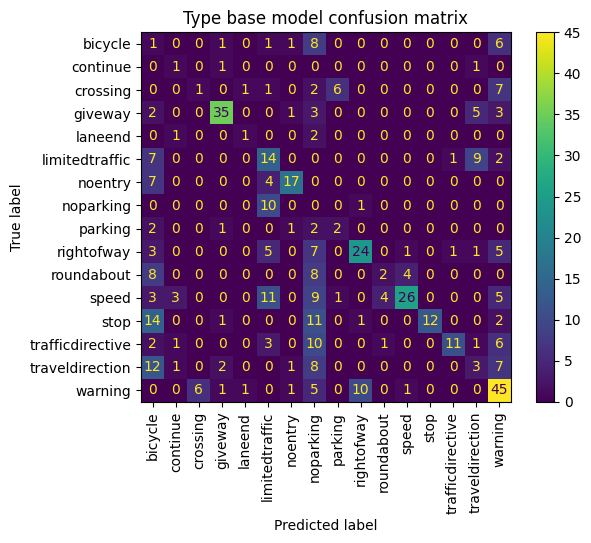

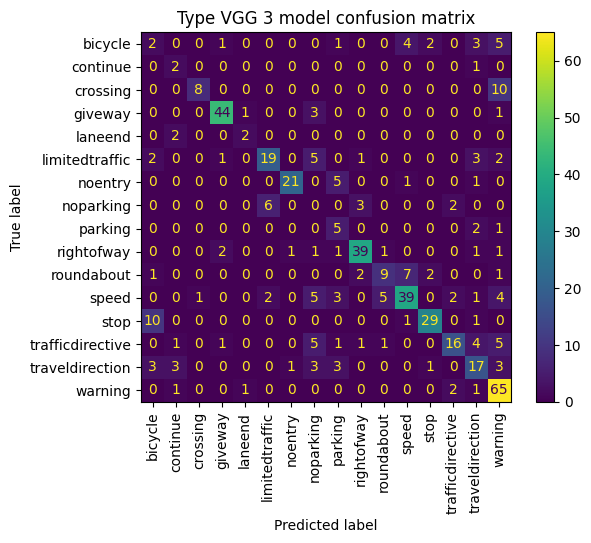

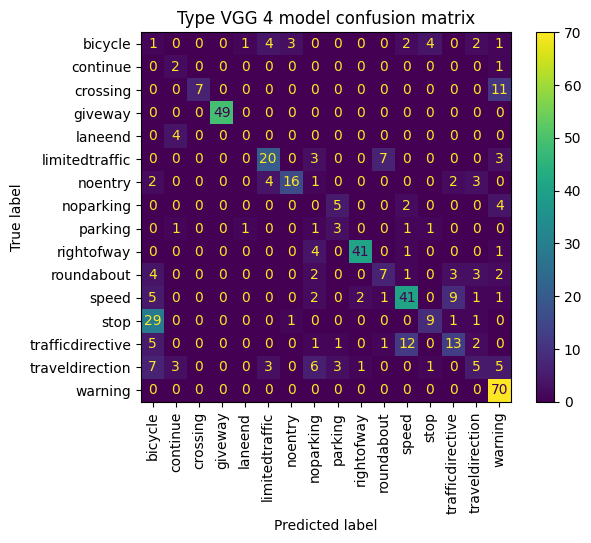

In [121]:
cm = confusion_matrix(new_data['Type'], new_data['Type base model'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=type_class_labels)
disp.plot()
plt.title("Type base model confusion matrix")
plt.xticks(rotation = 'vertical')
plt.show()

cm2 = confusion_matrix(new_data['Type'], new_data['Type VGG 3 model'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=type_class_labels)
disp.plot()
plt.title("Type VGG 3 model confusion matrix")
plt.xticks(rotation = 'vertical')
plt.show()

cm3 = confusion_matrix(new_data['Type'], new_data['Type VGG 4 model'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=type_class_labels)
disp.plot()
plt.title("Type VGG 4 model confusion matrix")
plt.xticks(rotation = 'vertical')
plt.show()